# Requirements

- Python 3.6.2 (NOT python 3.7)
- Sign up for an Intrinio account at https://intrinio.com/ and obtain an API key. Subscription to the 'US Fundamentals and Stock Prices' subscription (free, trial or paid) is required.

Python libaries:
- TensorFlow r1.13
- keras
- requests
- pandas
- matplotlib
- seaborn

# A deep learning price prediction model with TensorFlow

## Download the dataset

### NOTE: Replaced Original Data Loading Section

The original cells for data loading and technical indicator calculation (from the Intrinio API) have been removed and replaced with the single code block below.

**Reason:** The original code relied on the Intrinio API, which requires a paid subscription for technical indicator data, causing errors. This new block uses the free `yfinance` and `pandas-ta` libraries to download the raw price data and calculate the same indicators locally. This is a more modern and robust approach that does not require a paid API key.

In [2]:
# FIX 1: Install the necessary modern libraries
!pip install yfinance pandas-ta

# FIX 2: Import all libraries
import yfinance as yf
import pandas_ta as ta
import pandas as pd
import numpy as np

# --- 1. Define Parameters ---
ticker = 'AAPL'
start_date = '2013-01-01'
end_date = '2018-12-31'

# --- 2. Download Raw Price Data ---
print(f"Downloading OHLCV data for {ticker}...")
prices_df = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)

# --- 3. Check for Download Errors and Clean the DataFrame ---
if prices_df.empty:
    raise ValueError("Data download failed. Please wait a few minutes and try again.")

# FIX 3: Flatten the multi-level column headers into single-level names
if isinstance(prices_df.columns, pd.MultiIndex):
    prices_df.columns = prices_df.columns.get_level_values(0)

print("Data downloaded and cleaned successfully.")

# --- 4. Calculate All Technical Indicators ---
print("Calculating technical indicators...")

# FIX 4: Explicitly tell the functions which columns to use.
# This solves the AttributeError by bypassing the auto-detection.
prices_df.ta.rsi(close=prices_df['Close'], length=14, append=True)
prices_df.ta.willr(high=prices_df['High'], low=prices_df['Low'], close=prices_df['Close'], length=14, append=True)
prices_df.ta.ao(high=prices_df['High'], low=prices_df['Low'], fast=5, slow=34, append=True)
prices_df.ta.sma(close=prices_df['Close'], length=5, append=True)
prices_df.ta.sma(close=prices_df['Close'], length=15, append=True)
prices_df.ta.sma(close=prices_df['Close'], length=30, append=True)
prices_df.ta.vwap(high=prices_df['High'], low=prices_df['Low'], close=prices_df['Close'], volume=prices_df['Volume'], append=True)
prices_df.ta.ad(high=prices_df['High'], low=prices_df['Low'], close=prices_df['Close'], volume=prices_df['Volume'], append=True)

# --- 5. Prepare the Final DataFrame for the Model ---
df = prices_df.rename(columns={
    'RSI_14': 'rsi',
    'WILLR_14': 'wr',
    'AO_5_34': 'ao',
    'SMA_5': 'sma_5d',
    'SMA_15': 'sma_15d',
    'SMA_30': 'sma_30d',
    'VWAP_D': 'vwap',
    'AD': 'adtv',
    'Close': 'adj_close_price'
}).dropna()

print("All indicators calculated successfully.")
df.tail()

Data downloaded and cleaned successfully.
Calculating technical indicators...
All indicators calculated successfully.


Price,adj_close_price,High,Low,Open,Volume,rsi,wr,ao,sma_5d,sma_15d,sma_30d,vwap,adtv
Date,,,,,,,,,,,,,
2018-12-21,35.905136,37.675026,35.643109,37.365354,382978400,24.833750,-96.884763,-4.651044,38.039958,40.106653,42.225437,36.407757,-7.628761e+08
2018-12-24,34.976120,36.100463,34.918949,35.290553,148676800,22.983626,-99.329594,-5.017147,37.224809,39.602446,41.735840,35.331844,-8.971645e+08
2018-12-26,37.439190,37.453482,34.949914,35.326284,234330000,36.492564,-62.469012,-5.342882,36.800798,39.163348,41.360264,36.614195,-6.655099e+08
2018-12-27,37.196224,37.343916,35.747921,37.122380,212468400,35.825023,-65.734709,-5.468303,36.574976,38.837161,41.058375,36.762687,-4.923647e+08
2018-12-28,37.215279,37.760778,36.815090,37.517804,169165600,35.924016,-62.894539,-5.222501,36.546390,38.543530,40.772525,37.263716,-5.183581e+08


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training model...
Training complete.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

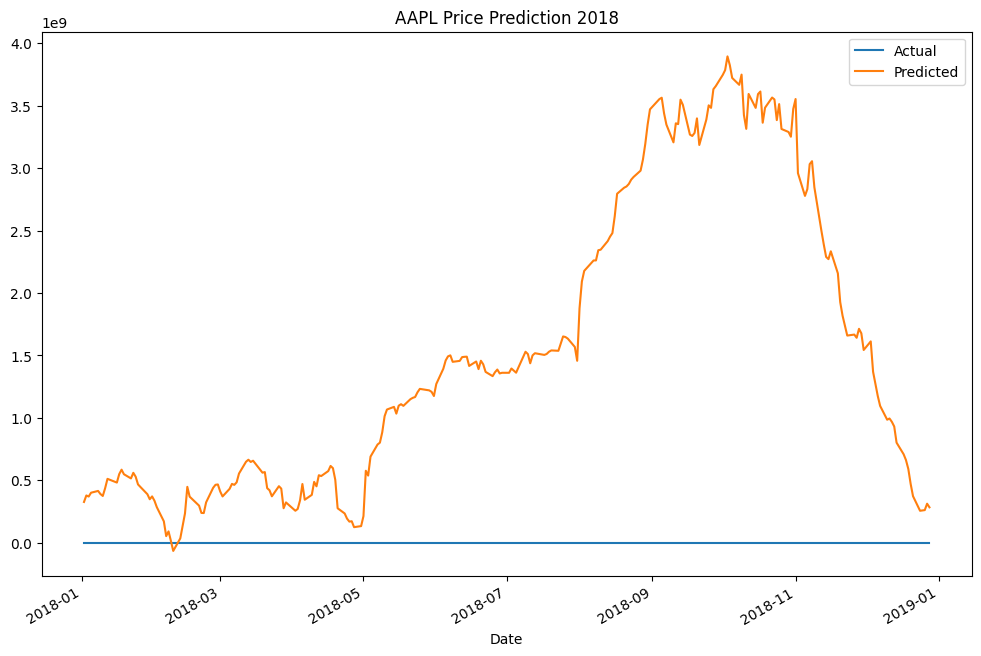

In [3]:
# --- All necessary libraries are already imported, so we continue ---
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# --- 1. Splitting and Scaling the Data ---
df_train = df.loc['2013':'2017']
df_test = df.loc['2018']
scaler = MinMaxScaler(feature_range=(-1, 1))

# Prepare the data for the neural network
train_data = scaler.fit_transform(df_train)
test_data = scaler.transform(df_test)

x_train = train_data[:, :-1]
y_train = train_data[:, -1]
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

# --- 2. Build and Train the Modern Neural Network ---
model = Sequential([
    Dense(512, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1) # The final output layer
])

model.compile(optimizer='adam', loss='mse')
print("\nTraining model...")
history = model.fit(
    x_train, y_train,
    batch_size=100,
    epochs=100,
    validation_data=(x_test, y_test),
    verbose=0 # Set to 1 to see epoch-by-epoch progress
)
print("Training complete.")

# --- 3. Make and Plot Predictions ---
predicted_scaled = model.predict(x_test)

# Reverse the scaling to get actual price predictions
predicted_prices = scaler.inverse_transform(
    np.hstack((x_test, predicted_scaled))
)[:, -1]

df_result = pd.DataFrame({
    'Actual': df_test['adj_close_price'].values,
    'Predicted': predicted_prices
}, index=df_test.index)

# Plot the Actual vs. Predicted prices
df_result.plot(figsize=(12, 8), title='AAPL Price Prediction 2018')
plt

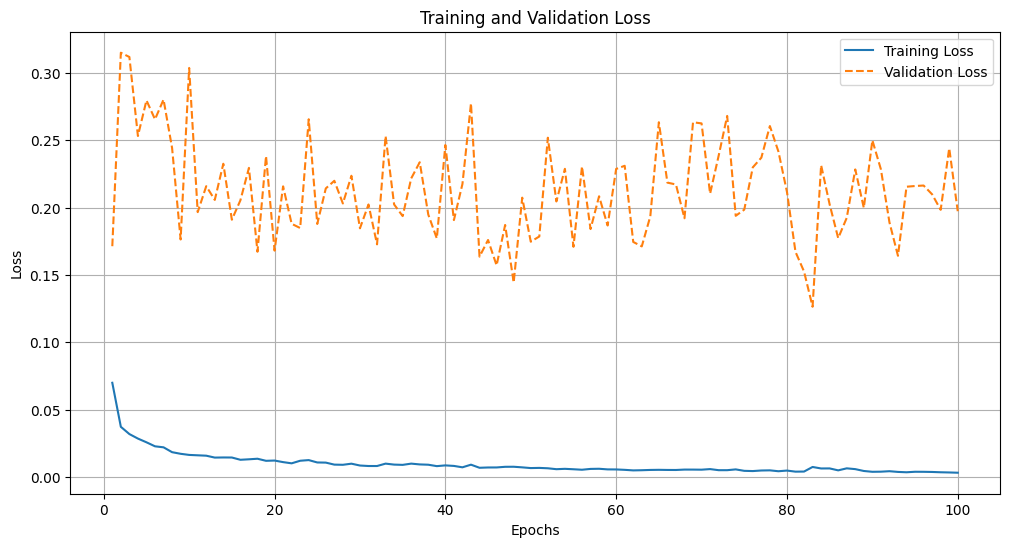

In [8]:
import matplotlib.pyplot as plt

# Extract Loss Only
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, '--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
